In [1]:
import numpy as np
import pandas
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import datetime

In [2]:
# 2022 시작일 때 f1 score가 모두 0.62로 높음

start = "2018-01-01"
today = str(datetime.date.today()-datetime.timedelta(1))
df = web.DataReader("SPY", data_source="yahoo", start=start, end=today)[["Open", "High", "Low", "Close"]]
df.dropna()

,Open,High,Low,Close
Date,,,,
2018-01-02,267.839996,268.809998,267.399994,268.769989
2018-01-03,268.959991,270.640015,268.959991,270.470001
2018-01-04,271.200012,272.160004,270.540009,271.609985
2018-01-05,272.510010,273.559998,271.950012,273.420013
2018-01-08,273.309998,274.100006,272.980011,273.920013
...,...,...,...,...
2022-04-27,417.239990,422.920013,415.010010,417.269989
2022-04-28,422.290009,429.640015,417.600006,427.809998
2022-04-29,423.589996,425.869995,411.209991,412.000000


In [3]:
# data preprocessing

def get_MACD(df, short=12, long=26, signal=9):
    df["MACD"] = df["Close"].ewm(span=short, min_periods=short-1, adjust=False).mean() - df["Close"].ewm(span=long, min_periods=long-1, adjust=False).mean()
    return df

df["MA10"] = df["Close"].rolling(window=10).mean()
df["Corr"] = df["Close"].rolling(window=10).corr(df["MA10"])
df["Open-Close"] = df["Open"]-df["Close"].shift(1)
df["Open-Open"] = df["Open"]-df["Open"].shift(1)
df = get_MACD(df)
df = df.dropna()

X1 = df[["Open", "Close", "Open-Close", "Open-Open"]]
X2 = df[["Open", "Close", "Open-Close", "Open-Open", "MACD"]]
X3 = df[["Open", "High", "Low", "Close", "Open-Close", "Open-Open", "MA10", "Corr", "MACD"]]


y = np.where(df["Close"].shift(-1) > df["Close"], 1, 0)



train_pct = 0.8
split = int(train_pct*len(df))

X1_train, X1_test = X1[:split], X1[split:]
X2_train, X2_test = X2[:split], X2[split:]
X3_train, X3_test = X3[:split], X3[split:]

y_train, y_test =  y[:split], y[split:]

In [4]:
def train_pred(model, dataset):
    model = sklearn.base.clone(model)  # 깊은 복사. 이거 안하면 오브젝트 하나를 계속 학습시키게 됨
    model.fit(dataset[0], dataset[1])
    score = model.score(dataset[2], dataset[3])
    print(score)
    return model, score

models = [LogisticRegression(), RandomForestClassifier(), XGBClassifier(use_label_encoder=False)]
datasets = [
    [X1_train, y_train, X1_test, y_test],
    [X2_train, y_train, X2_test, y_test],
    [X3_train, y_train, X3_test, y_test],
]

# train, scoring
scores = []
trained_models = {}
for model_index in range(len(models)):
    for dataset_index in range(len(datasets)):
        print(f"model-{model_index} dataset-{dataset_index}==============")
        model, score = train_pred(models[model_index], datasets[dataset_index])
        scores.append([f"model-{model_index} dataset-{dataset_index}", score])
        trained_models[f"model-{model_index} dataset-{dataset_index}"] = model

model-0 dataset-0==============
0.5327102803738317
model-0 dataset-1==============
0.5327102803738317
model-0 dataset-2==============
0.5420560747663551
model-1 dataset-0==============


C:\Users\USER\anaconda3\envs\data\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


0.5280373831775701
model-1 dataset-1==============
0.5373831775700935
model-1 dataset-2==============
0.5093457943925234
model-2 dataset-0==============
[21:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5747663551401869
model-2 dataset-1==============
[21:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.5887850467289719
model-2 dataset-2==============
[21:21:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3

In [5]:
top_score = max(scores, key=lambda x: x[1])
top_score

['model-2 dataset-1', 0.5887850467289719]

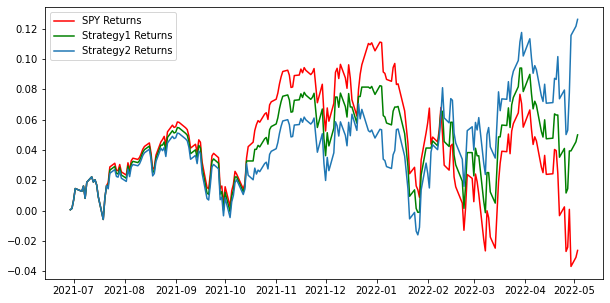

In [6]:
# 매매 실행

df["Signal1"] = trained_models["model-0 dataset-0"].predict(X1)
df["Signal2"] = df["Signal1"].replace(0, -1)  # 하락이 예상될 때 공매도를 치는 전략

df["SPY_Returns"] = np.log(df["Close"] / df["Close"].shift(1))  # SNP 일간수익률
Cum_SPY_Returns = np.cumsum(df[split:]["SPY_Returns"])  # SNP 누적수익률

df["STR1_Returns"] = df["SPY_Returns"] * df["Signal1"].shift(1)
Cum_STR1_Returns = np.cumsum(df[split:]["STR1_Returns"])

df["STR2_Returns"] = df["SPY_Returns"] * df["Signal2"].shift(1)
Cum_STR2_Returns = np.cumsum(df[split:]["STR2_Returns"])

plt.figure(figsize=(10, 5))
plt.plot(Cum_SPY_Returns, color='r', label="SPY Returns")
plt.plot(Cum_STR1_Returns, color='g', label="Strategy1 Returns")
plt.plot(Cum_STR2_Returns, label="Strategy2 Returns")
plt.legend()
plt.show()

In [7]:
# 샤프비율 계산
Std1= Cum_STR1_Returns.std()
Sharpe1 = (Cum_STR1_Returns - Cum_SPY_Returns)/Std1
Sharpe1 = Sharpe1.mean()
print("Sharpe1 ratio :", Sharpe1)

Std2= Cum_STR2_Returns.std()
Sharpe2 = (Cum_STR2_Returns - Cum_SPY_Returns)/Std2
Sharpe2 = Sharpe2.mean()
print("Sharpe2 ratio :", Sharpe2)

Sharpe1 ratio : -0.016803230804675513
Sharpe2 ratio : -0.02918982814662933


In [8]:
predicted1 = trained_models["model-0 dataset-0"].predict(X1_test)
print("confusion matrix==========================")
print(metrics.confusion_matrix(y_test, predicted1))
print("classification report==========================")
print(metrics.classification_report(y_test, predicted1))

confusion matrix==========================
[[ 12  88]
 [ 12 102]]
classification report==========================
              precision    recall  f1-score   support

           0       0.50      0.12      0.19       100
           1       0.54      0.89      0.67       114

    accuracy                           0.53       214
   macro avg       0.52      0.51      0.43       214
weighted avg       0.52      0.53      0.45       214

